<a href="https://colab.research.google.com/github/Quadwo/ImageNet-Datasets-Downloader/blob/master/notebooks/how-to-finetune-rf-detr-on-segmentation-dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train RF-DETR Segmentation on a Custom Dataset

---

[![hf space](https://img.shields.io/badge/%F0%9F%A4%97%20Hugging%20Face-Spaces-blue)](https://huggingface.co/spaces/SkalskiP/RF-DETR)
[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-finetune-rf-detr-on-detection-dataset.ipynb)
[![roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/rf-detr-segmentation)
[![code](https://badges.aleen42.com/src/github.svg)](https://github.com/roboflow/rf-detr)

RF-DETR is a real-time transformer architecture for object detection and instance segmentation developed by Roboflow. Built on a DINOv2 vision transformer backbone, RF-DETR delivers state-of-the-art accuracy and latency trade-offs on [Microsoft COCO](https://cocodataset.org/#home) and [RF100-VL](https://github.com/roboflow/rf100-vl).

RF-DETR uses a DINOv2 vision transformer backbone and supports both detection and instance segmentation in a single, consistent API. All core models and code are released under the Apache 2.0 license.

<img alt="rf_detr_1-4_latency_accuracy_instance_segmentation" src="https://storage.googleapis.com/com-roboflow-marketing/rf-detr/rf_detr_1-4_latency_accuracy_instance_segmentation.png" />

## Environment setup

### Configure API Key

To fine-tune RF-DETR, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy` to copy your private API key.
- In Colab, go to the left pane and click on `Secrets` (🔑).
    - Store your Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [ ]:
import os
from google.colab import userdata

os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")

### Check GPU availability

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Thu Jan 22 19:20:00 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   31C    P8             11W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Install dependencies

Installs RF-DETR version 1.4.0 or higher, along with Supervision for visualizations and Roboflow for pulling datasets and uploading models to the Roboflow platform.

In [ ]:
!pip install -q rfdetr>=1.4.0 supervision roboflow

### Download example data

Downloads example images for testing. You can use these or replace them with your own images.

In [ ]:
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg

## Inference with Pre-trained COCO Model

Runs inference on an example image using the RF-DETR Segmentation Preview model (Medium checkpoint trained on COCO).

In [ ]:
from rfdetr import RFDETRSegMedium
from rfdetr.util.coco_classes import COCO_CLASSES

model = RFDETRSegMedium()
model.optimize_for_inference()

rf-detr-seg-preview.pt: 100%|██████████| 130M/130M [00:01<00:00, 69.0MiB/s]


Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 12 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


In [ ]:
import supervision as sv
from PIL import Image

def annotate(image: Image.Image, detections: sv.Detections, classes: dict[int, str]) -> Image.Image:
    color = sv.ColorPalette.from_hex([
        "#ffff00", "#ff9b00", "#ff8080", "#ff66b2", "#ff66ff", "#b266ff",
        "#9999ff", "#3399ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
    ])
    text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)

    mask_annotator = sv.MaskAnnotator(color=color)
    polygon_annotator = sv.PolygonAnnotator(color=sv.Color.WHITE)
    label_annotator = sv.LabelAnnotator(
        color=color,
        text_color=sv.Color.BLACK,
        text_scale=text_scale,
        text_position=sv.Position.CENTER_OF_MASS
    )

    labels = [
        f"{classes.get(class_id, 'unknown')} {confidence:.2f}"
        for class_id, confidence in zip(detections.class_id, detections.confidence)
    ]

    out = image.copy()
    out = mask_annotator.annotate(out, detections)
    out = polygon_annotator.annotate(out, detections)
    out = label_annotator.annotate(out, detections, labels)
    out.thumbnail((1000, 1000))
    return out

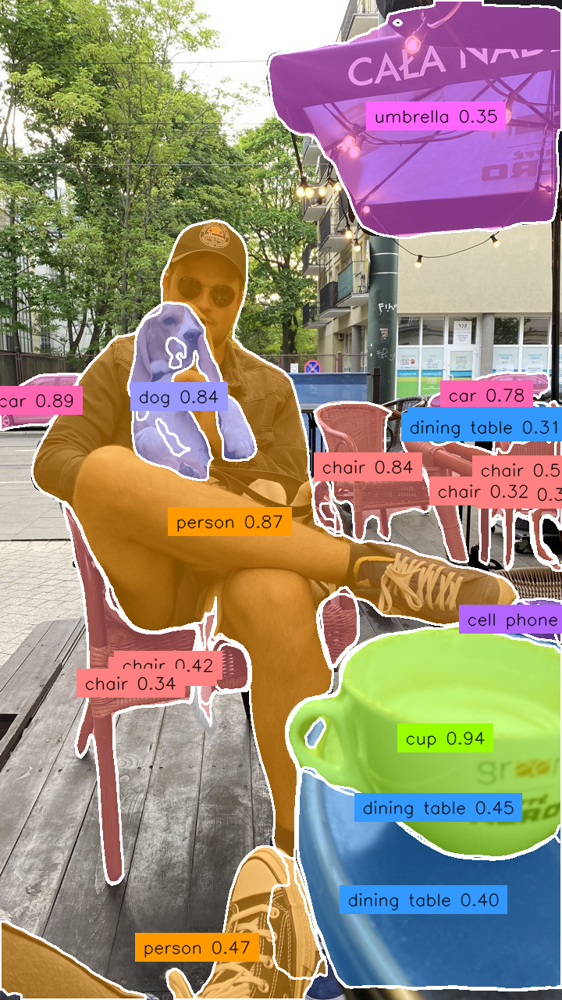

In [ ]:
image = Image.open("dog-3.jpeg")

detections = model.predict(image, threshold=0.3)

annotated_image = annotate(image, detections, classes=COCO_CLASSES)
annotated_image

## Download Dataset from Roboflow Universe

RF-DETR expects the dataset to be in COCO format. Divide your dataset into three subdirectories: `train`, `valid`, and `test`. Each subdirectory should contain its own `_annotations.coco.json` file that holds the annotations for that particular split, along with the corresponding image files. Below is an example of the directory structure:

```
dataset/
├── train/
│   ├── _annotations.coco.json
│   ├── image1.jpg
│   ├── image2.jpg
│   └── ... (other image files)
├── valid/
│   ├── _annotations.coco.json
│   ├── image1.jpg
│   ├── image2.jpg
│   └── ... (other image files)
└── test/
    ├── _annotations.coco.json
    ├── image1.jpg
    ├── image2.jpg
    └── ... (other image files)
```

[Roboflow](https://roboflow.com/annotate) allows you to create segmentation datasets from scratch or convert existing datasets from formats like YOLO, and then export them in COCO JSON format for training. You can also explore [Roboflow Universe](https://universe.roboflow.com/) to find pre-labeled segmentation datasets for a range of use cases.

In [ ]:
from roboflow import download_dataset

dataset = download_dataset("https://universe.roboflow.com/roboflow-jvuqo/creacks-eapny/4", "coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to creacks-4 in coco:: 100%|██████████| 4036/4036 [00:00<00:00, 5172.87it/s]


## Train RF-DETR on custom dataset

### Choose the right `batch_size`

Different GPUs have different amounts of VRAM (video memory), which limits how much data they can handle at once during training. To make training work well on any machine, you can adjust two settings: `batch_size` and `grad_accum_steps`. These control how many samples are processed at a time. The key is to keep their product equal to 16 — that’s our recommended total batch size. For example, on powerful GPUs like the A100, set `batch_size=16` and `grad_accum_steps=1`. On smaller GPUs like the T4, use `batch_size=4` and `grad_accum_steps=4`. We use a method called gradient accumulation, which lets the model simulate training with a larger batch size by gradually collecting updates before adjusting the weights.

In [ ]:
from rfdetr import RFDETRSegNano

model = RFDETRSegNano()

model.train(dataset_dir=dataset.location, epochs=5, batch_size=4, grad_accum_steps=4)

rf-detr-seg-nano.pt: 100%|██████████| 128M/128M [00:01<00:00, 87.1MiB/s]


Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 12 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights
TensorBoard logging initialized. To monitor logs, use 'tensorboard --logdir output' and open http://localhost:6006/ in browser.
Not using distributed mode
git:
  sha: N/A, status: clean, branch: N/A

Namespace(num_classes=2, grad_accum_steps=4, amp=True, lr=0.0001, lr_encoder=0.00015, batch_size=4, weight_decay=0.0001, epochs=5, lr_drop=100, clip_max_norm=0.1, lr_vit_layer_decay=0.8, lr_component_decay=0.7, do_benchmark=False, dropout=0, drop_path=0.0, drop_mode='standard', drop_schedule='constant', cutoff_epoch=0, pretrained_encoder=None, pretrain_weights='rf-detr-seg-nano.pt', pretrain_exclude_keys=None, pretrain_keys_modify_to_lo

Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an erro

Epoch: [0]  [  0/232]  eta: 0:17:42  lr: 0.000100  class_error: 0.00  loss: 58.9943 (58.9943)  loss_ce: 3.3482 (3.3482)  loss_bbox: 2.0253 (2.0253)  loss_giou: 1.3108 (1.3108)  loss_mask_ce: 1.5741 (1.5741)  loss_mask_dice: 3.9249 (3.9249)  loss_ce_0: 2.0879 (2.0879)  loss_bbox_0: 2.1748 (2.1748)  loss_giou_0: 1.8783 (1.8783)  loss_mask_ce_0: 1.2184 (1.2184)  loss_mask_dice_0: 3.9518 (3.9518)  loss_ce_1: 2.5202 (2.5202)  loss_bbox_1: 1.9329 (1.9329)  loss_giou_1: 1.6984 (1.6984)  loss_mask_ce_1: 1.1902 (1.1902)  loss_mask_dice_1: 3.8631 (3.8631)  loss_ce_2: 3.3602 (3.3602)  loss_bbox_2: 1.9179 (1.9179)  loss_giou_2: 1.4107 (1.4107)  loss_mask_ce_2: 1.4135 (1.4135)  loss_mask_dice_2: 3.8879 (3.8879)  loss_ce_enc: 2.9323 (2.9323)  loss_bbox_enc: 2.5744 (2.5744)  loss_giou_enc: 1.5341 (1.5341)  loss_mask_ce_enc: 1.4581 (1.4581)  loss_mask_dice_enc: 3.8061 (3.8061)  loss_ce_unscaled: 0.6696 (0.6696)  class_error_unscaled: 0.0000 (0.0000)  loss_bbox_unscaled: 0.4051 (0.4051)  loss_giou_unsc

Mean of empty slice
Mean of empty slice
Mean of empty slice


Test:  [ 0/50]  eta: 0:00:38  class_error: 0.00  loss: 38.3987 (38.3987)  loss_ce: 5.0625 (5.0625)  loss_bbox: 0.2470 (0.2470)  loss_giou: 0.1739 (0.1739)  loss_mask_ce: 0.3144 (0.3144)  loss_mask_dice: 1.2015 (1.2015)  loss_ce_0: 4.6875 (4.6875)  loss_bbox_0: 0.6060 (0.6060)  loss_giou_0: 0.6456 (0.6456)  loss_mask_ce_0: 0.3987 (0.3987)  loss_mask_dice_0: 1.4990 (1.4990)  loss_ce_1: 4.7188 (4.7188)  loss_bbox_1: 0.5016 (0.5016)  loss_giou_1: 0.5450 (0.5450)  loss_mask_ce_1: 0.4024 (0.4024)  loss_mask_dice_1: 1.5629 (1.5629)  loss_ce_2: 4.7188 (4.7188)  loss_bbox_2: 0.3270 (0.3270)  loss_giou_2: 0.3854 (0.3854)  loss_mask_ce_2: 0.4252 (0.4252)  loss_mask_dice_2: 1.4011 (1.4011)  loss_ce_enc: 4.9062 (4.9062)  loss_bbox_enc: 0.6920 (0.6920)  loss_giou_enc: 0.6588 (0.6588)  loss_mask_ce_enc: 0.4926 (0.4926)  loss_mask_dice_enc: 1.8249 (1.8249)  loss_ce_unscaled: 1.0156 (1.0156)  class_error_unscaled: 0.0000 (0.0000)  loss_bbox_unscaled: 0.0494 (0.0494)  loss_giou_unscaled: 0.0869 (0.0869)

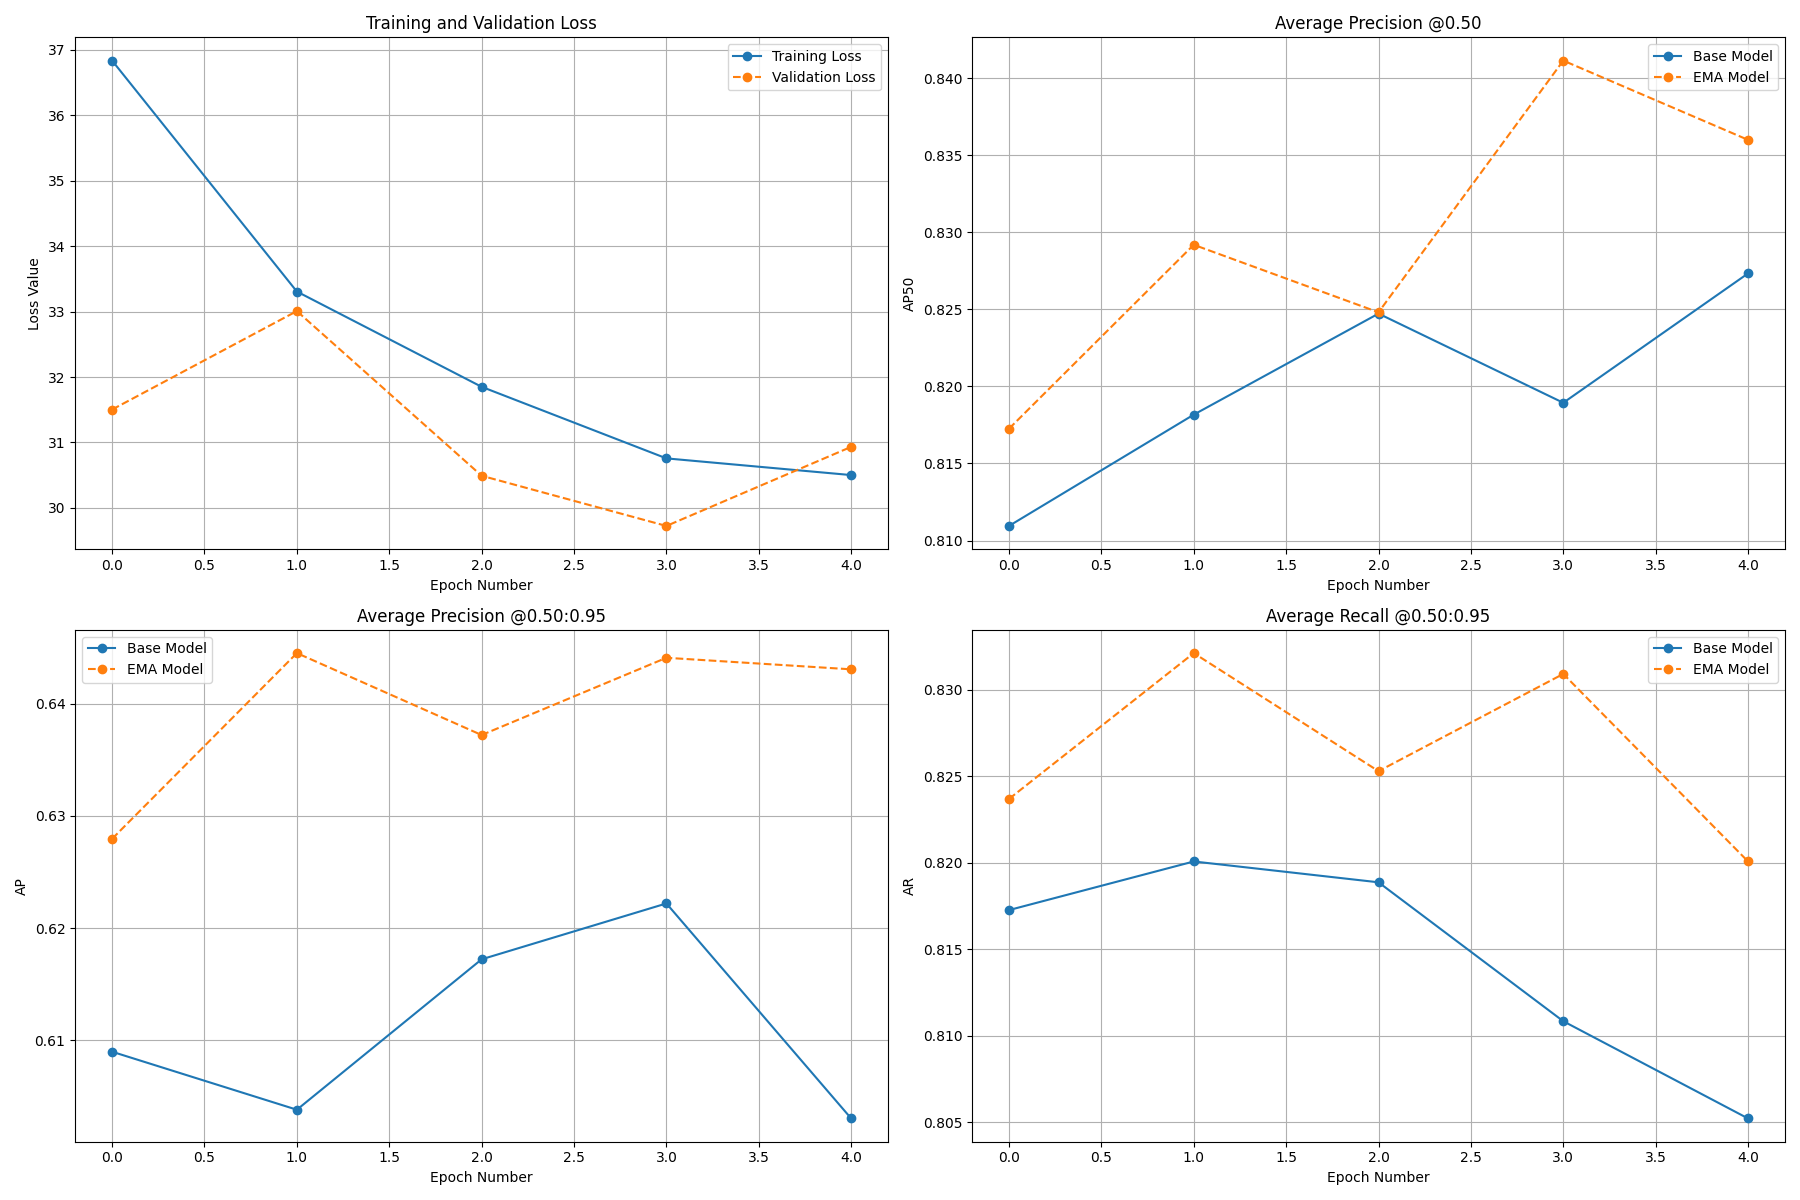

In [ ]:
from PIL import Image

Image.open("/content/output/metrics_plot.png")

In [ ]:
!ls -la /content/output

total 1434528
drwxr-xr-x 3 root root      4096 Jan 22 19:49 .
drwxr-xr-x 1 root root      4096 Jan 22 19:23 ..
-rw-r--r-- 1 root root 399873662 Jan 22 19:33 checkpoint_best_ema.pth
-rw-r--r-- 1 root root 401162826 Jan 22 19:28 checkpoint_best_regular.pth
-rw-r--r-- 1 root root 133254035 Jan 22 19:48 checkpoint_best_total.pth
-rw-r--r-- 1 root root 534387491 Jan 22 19:47 checkpoint.pth
drwxr-xr-x 2 root root      4096 Jan 22 19:28 eval
-rw-r--r-- 1 root root      2242 Jan 22 19:48 events.out.tfevents.1769109791.cda73ee9d5ec.1288.0
-rw-r--r-- 1 root root     51234 Jan 22 19:48 log.txt
-rw-r--r-- 1 root root    177246 Jan 22 19:49 metrics_plot.png
-rw-r--r-- 1 root root       705 Jan 22 19:49 results.json


## Deploy a Trained RF-DETR Model

Deploying to Roboflow allows you to create multi-step computer vision applications that run both in the cloud and your own hardware. Please wait a moment while Roboflow indexes your model.

In [ ]:
model.deploy_to_roboflow(
  workspace="roboflow-jvuqo",
  project_id="creacks-eapny",
  version=4,
  api_key=os.environ["ROBOFLOW_API_KEY"]
)

loading Roboflow workspace...
loading Roboflow project...
View the status of your deployment at: https://app.roboflow.com/roboflow-jvuqo/creacks-eapny/4
Share your model with the world at: https://universe.roboflow.com/roboflow-jvuqo/creacks-eapny/model/4


## Evaluate Fine-tuned RF-DETR Model

Before benchmarking the model, we need to load the best saved checkpoint. To ensure it fits on the GPU, we first need to free up GPU memory. This involves deleting any remaining references to previously used objects, triggering Python’s garbage collector, and clearing the CUDA memory cache.

In [ ]:
import gc
import torch
import weakref

def cleanup_gpu_memory(obj=None, verbose: bool = False):

    if not torch.cuda.is_available():
        if verbose:
            print("[INFO] CUDA is not available. No GPU cleanup needed.")
        return

    def get_memory_stats():
        allocated = torch.cuda.memory_allocated()
        reserved = torch.cuda.memory_reserved()
        return allocated, reserved

    torch.cuda.synchronize()

    if verbose:
        alloc, reserv = get_memory_stats()
        print(f"[Before] Allocated: {alloc / 1024**2:.2f} MB | Reserved: {reserv / 1024**2:.2f} MB")

    # Ensure we drop all strong references
    if obj is not None:
        ref = weakref.ref(obj)
        del obj
        if ref() is not None and verbose:
            print("[WARNING] Object not fully garbage collected yet.")

    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

    torch.cuda.synchronize()

    if verbose:
        alloc, reserv = get_memory_stats()
        print(f"[After]  Allocated: {alloc / 1024**2:.2f} MB | Reserved: {reserv / 1024**2:.2f} MB")

In [ ]:
cleanup_gpu_memory(model, verbose=True)

[Before] Allocated: 146.41 MB | Reserved: 3536.00 MB
[WARNING] Object not fully garbage collected yet.
[After]  Allocated: 146.41 MB | Reserved: 232.00 MB


We load the best-performing model from the `checkpoint_best_total.pth` file using the `RFDETRSegPreview` class. This checkpoint contains the trained weights from our most successful training run. After loading, we call `optimize_for_inference()`, which prepares the model for efficient inference.

In [ ]:
model = RFDETRSegNano(pretrain_weights="/content/output/checkpoint_best_total.pth")
model.optimize_for_inference()

## Run Inference with Fine-tuned RF-DETR Model

In [ ]:
import supervision as sv

ds_test = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/test",
    annotations_path=f"{dataset.location}/test/_annotations.coco.json",
    force_masks=True
)

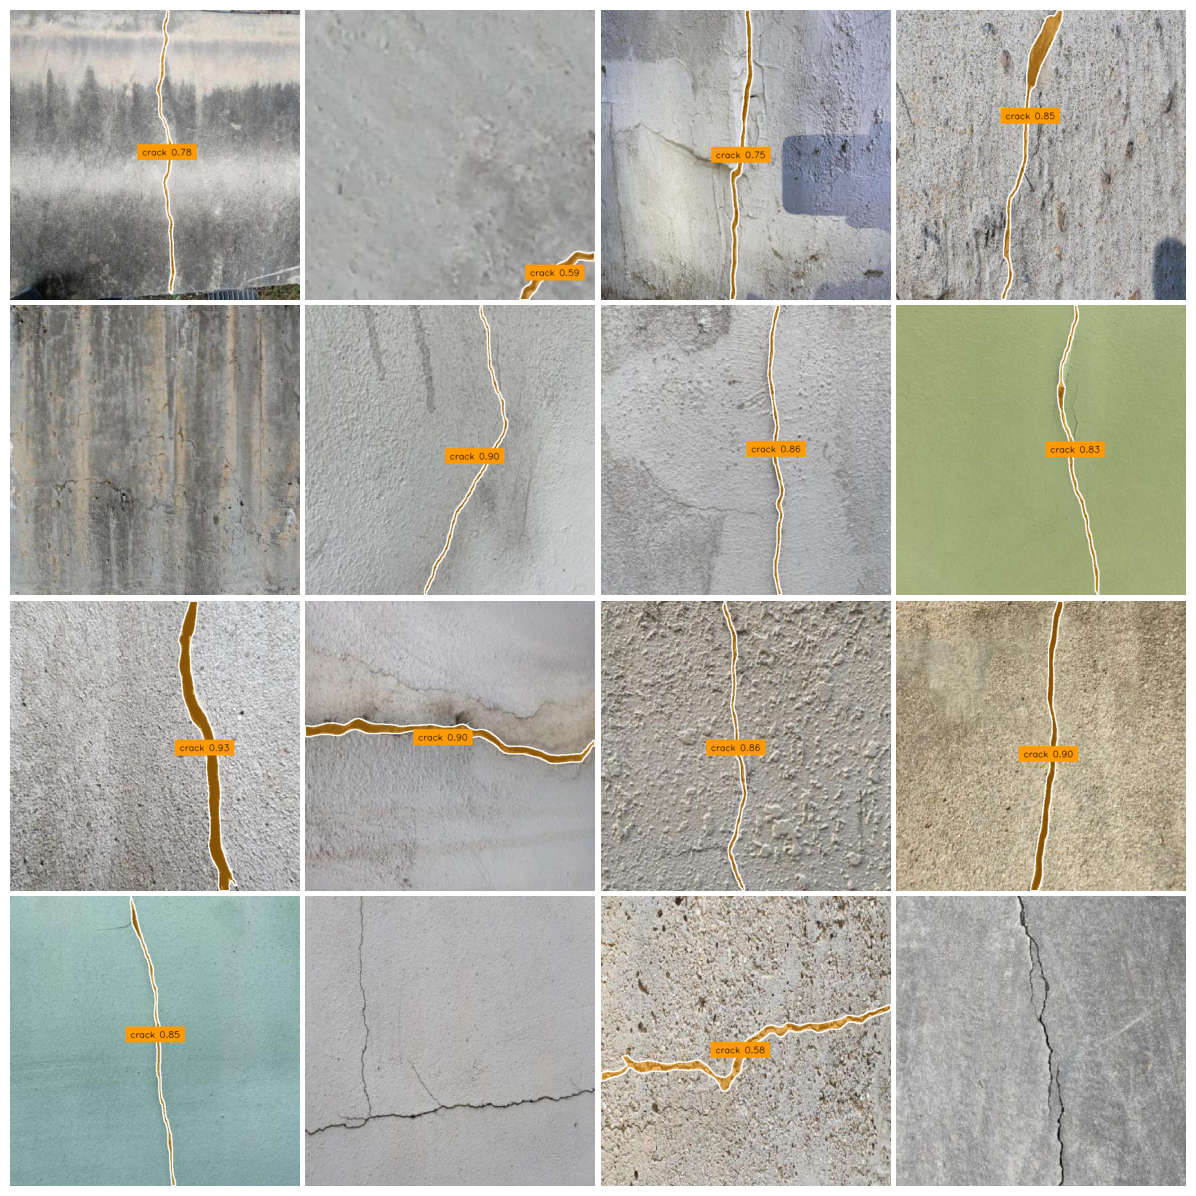

In [ ]:
import random
import matplotlib.pyplot as plt

N = 16
L = len(ds_test)

annotated_images = []

for i in random.sample(range(L), N):
    path, _, annotations = ds_test[i]
    image = Image.open(path)
    detections = model.predict(image, threshold=0.5)
    annotated_image = annotate(image, detections, classes={i: class_name for i, class_name in enumerate(ds_test.classes)})
    annotated_images.append(annotated_image)

fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for ax, img in zip(axes.flat, annotated_images):
    ax.imshow(img)
    ax.axis("off")

plt.subplots_adjust(wspace=0.02, hspace=0.02, left=0.01, right=0.99, top=0.99, bottom=0.01)

plt.show()

In [ ]:
!pip install -q inference

In [ ]:
from inference import get_model

MODEL_ID = "creacks-eapny/4"
model_rf = get_model(model_id=MODEL_ID, api_key = userdata.get("ROBOFLOW_API_KEY"))

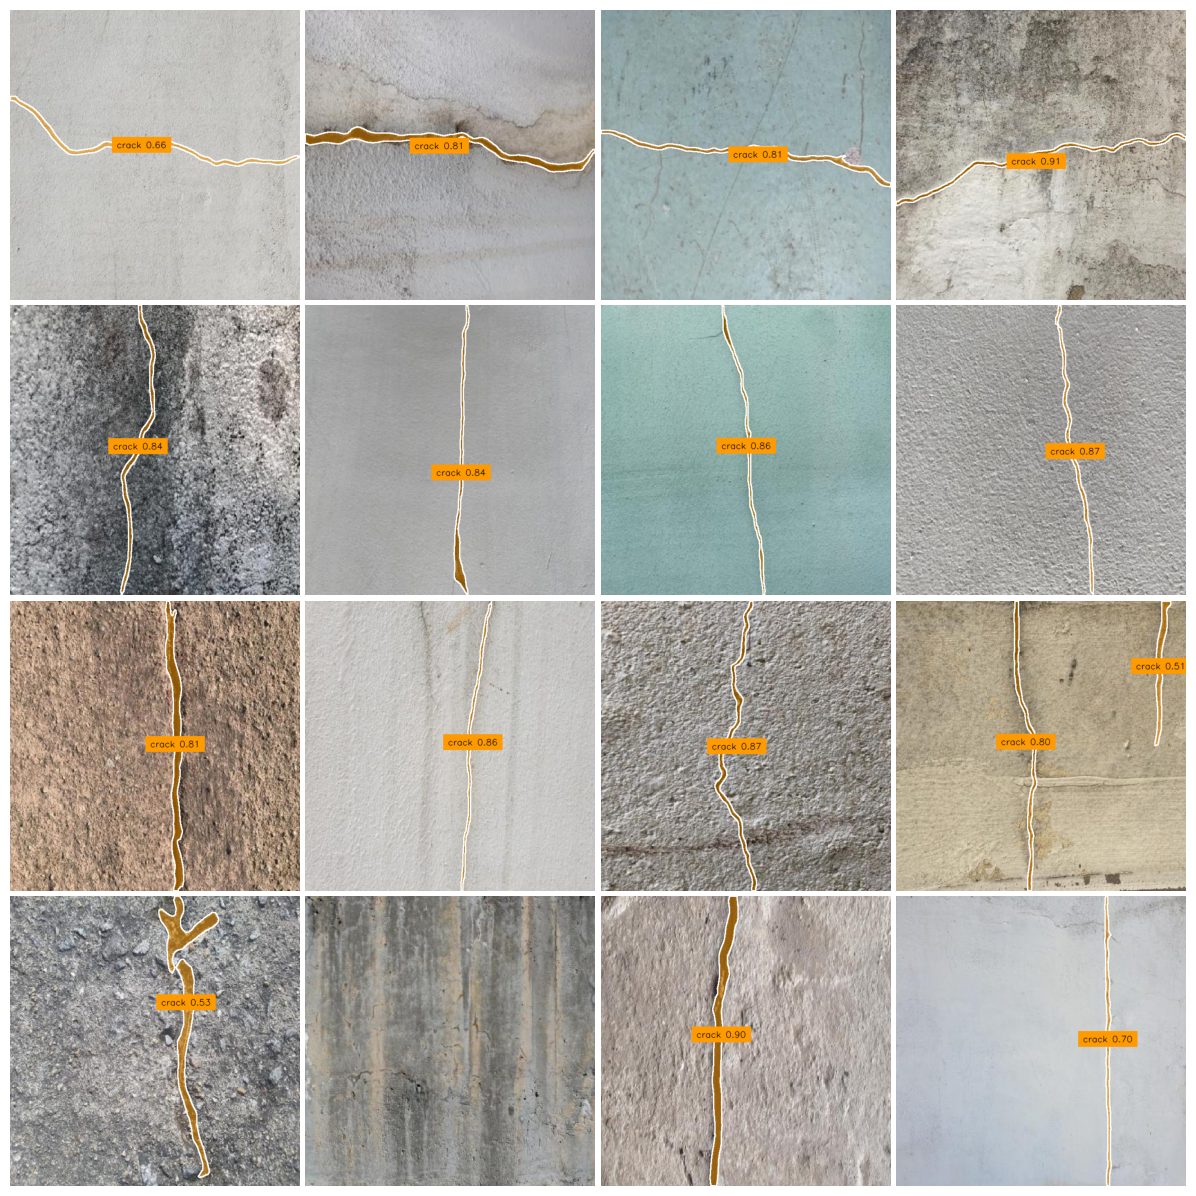

In [ ]:
import random
import matplotlib.pyplot as plt

N = 16
L = len(ds_test)

annotated_images = []

for i in random.sample(range(L), N):
    path, _, annotations = ds[i]
    image = Image.open(path)
    result = model_rf.infer(image, confidence=0.5)[0]
    detections = sv.Detections.from_inference(result)
    annotated_image = annotate(image, detections, classes={i: class_name for i, class_name in enumerate(ds_test.classes)})
    annotated_images.append(annotated_image)

fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for ax, img in zip(axes.flat, annotated_images):
    ax.imshow(img)
    ax.axis("off")

plt.subplots_adjust(wspace=0.02, hspace=0.02, left=0.01, right=0.99, top=0.99, bottom=0.01)

plt.show()

<div align="center">
  <p>
    Looking for more tutorials or have questions?
    Check out our <a href="https://github.com/roboflow/notebooks">GitHub repo</a> for more notebooks,
    or visit our <a href="https://discord.gg/GbfgXGJ8Bk">discord</a>.
  </p>
  
  <p>
    <strong>If you found this helpful, please consider giving us a ⭐
    <a href="https://github.com/roboflow/notebooks">on GitHub</a>!</strong>
  </p>

</div>